In [9]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, DenseNet121, InceptionV3
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
               
from transformers import ViTForImageClassification, ViTFeatureExtractor, TFAutoModelForImageClassification
from transformers import AdamW


In [10]:
def load_yolo():
    path_to_cfg = "yolo/yolov3.cfg" 
    path_to_weights = "yolo/yolov3.weights"
    net = cv2.dnn.readNet(path_to_weights, path_to_cfg)
    layers_names = net.getLayerNames()
    try:
        output_layers = [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except Exception:
        output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, output_layers

def yolo_detect(net, image, output_layers, confidence_threshold=0.3):
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    boxes = []
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_id == 0:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                if x >= 0 and y >= 0 and (x + w) <= width and (y + h) <= height:
                    boxes.append([x, y, w, h])
    return boxes

def load_and_preprocess_data(root_folder, net, output_layers):
    images = []
    labels = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    for player_name in os.listdir(root_folder):
        player_folder = os.path.join(root_folder, player_name)
        if os.path.isdir(player_folder):
            for img_file in os.listdir(player_folder):
                if img_file.lower().endswith(valid_extensions):
                    img_path = os.path.join(player_folder, img_file)
                    img = cv2.imread(img_path)
                    if img is None:
                        continue
                    boxes = yolo_detect(net, img, output_layers)
                    for box in boxes:
                        x, y, w, h = box
                        cropped_img = img[y:y+h, x:x+w]
                        resized_img = cv2.resize(cropped_img, (224, 224))  # Resize for ViT
                        images.append(resized_img)
                        labels.append(player_name)
    return np.array(images), labels

In [11]:
from transformers import AdamWeightDecay, create_optimizer
import tensorflow as tf

def build_model(num_classes,encoder):
    model = TFAutoModelForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        num_labels=num_classes,
        id2label={str(i): label for i, label in enumerate(encoder.classes_)},
        label2id={label: str(i) for i, label in enumerate(encoder.classes_)}
    )
    return model


def compile_and_train(model, X_train, y_train, X_val, y_val, epochs=5):
    optimizer = AdamWeightDecay(learning_rate=3e-5, weight_decay_rate=0.01)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val))
    return history





In [12]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(X_test, y_test, model, encoder):
    # Predict the probabilities for the test data
    y_probs = model.predict(X_test)['logits'] 
    y_pred = np.argmax(y_probs, axis=-1)  # Using axis=-1 to be dimension agnostic
    y_true = np.argmax(y_test, axis=1)

    # Verify dimensions and handling for precision-recall calculations
    if y_probs.ndim == 1:
        y_probs = np.expand_dims(y_probs, axis=0)

    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(encoder.classes_)):
        if y_test[:, i].ndim == 1:
            y_test[:, i] = np.expand_dims(y_test[:, i], axis=0)
        if y_probs[:, i].ndim == 1:
            y_probs[:, i] = np.expand_dims(y_probs[:, i], axis=0)
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_probs[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_probs[:, i])

    mAP = np.mean(list(average_precision.values()))

    # Generate classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=encoder.classes_))

    f1 = f1_score(y_true, y_pred, average='macro') 
    print("F1 Score (macro-average):", f1)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Mean Average Precision (mAP):", mAP)

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [13]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

/Users/pubudusenarathne/Library/Python/3.9/lib/python/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were no

Epoch 1/5
667/667 [==============================] - 2896s 4s/step - loss: 2.3217 - accuracy: 0.2580 - val_loss: 1.2820 - val_accuracy: 0.1080
Epoch 2/5
667/667 [==============================] - 2886s 4s/step - loss: 2.0965 - accuracy: 0.1493 - val_loss: 2.0920 - val_accuracy: 0.3881
Epoch 3/5
667/667 [==============================] - 2839s 4s/step - loss: 2.4040 - accuracy: 0.2412 - val_loss: 1.2397 - val_accuracy: 0.4038
Epoch 4/5
667/667 [==============================] - 2838s 4s/step - loss: 3.0187 - accuracy: 0.4218 - val_loss: 8.4481 - val_accuracy: 0.5456
Epoch 5/5
667/667 [==============================] - 2833s 4s/step - loss: 6.0098 - accuracy: 0.4040 - val_loss: 2.0497 - val_accuracy: 0.5114


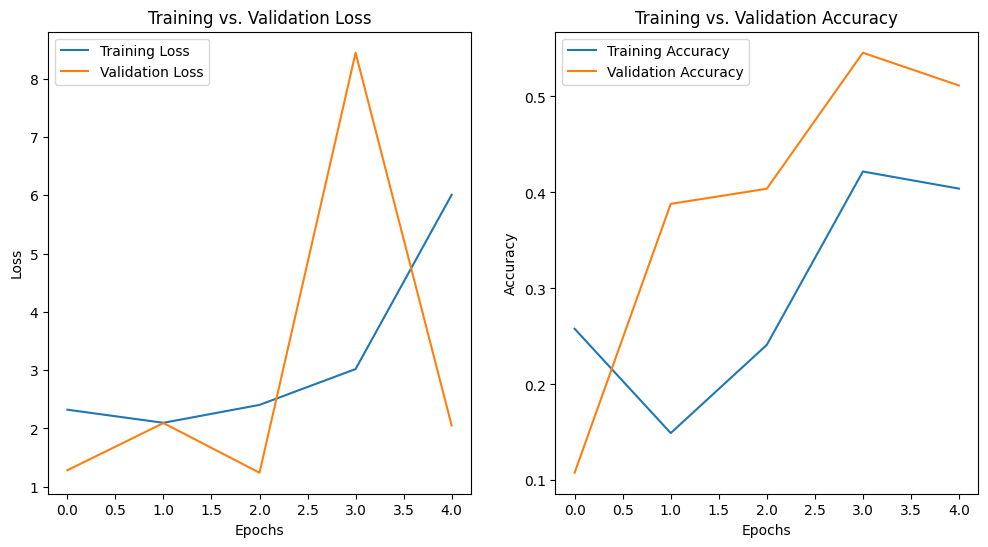

84/84 [==============================] - 223s 3s/step
Classification Report:
                 precision    recall  f1-score   support

     Axar_Patel       0.50      0.74      0.60       993
  Kuldeep_Yadav       0.45      0.40      0.42       474
Ravindra_Jadeja       0.57      0.24      0.34       571
    Virat_Kohli       0.57      0.48      0.52       629

       accuracy                           0.51      2667
      macro avg       0.52      0.47      0.47      2667
   weighted avg       0.52      0.51      0.49      2667

F1 Score (macro-average): 0.47000779288034167
Accuracy: 0.5114360704911886
Mean Average Precision (mAP): 0.4309001207919875


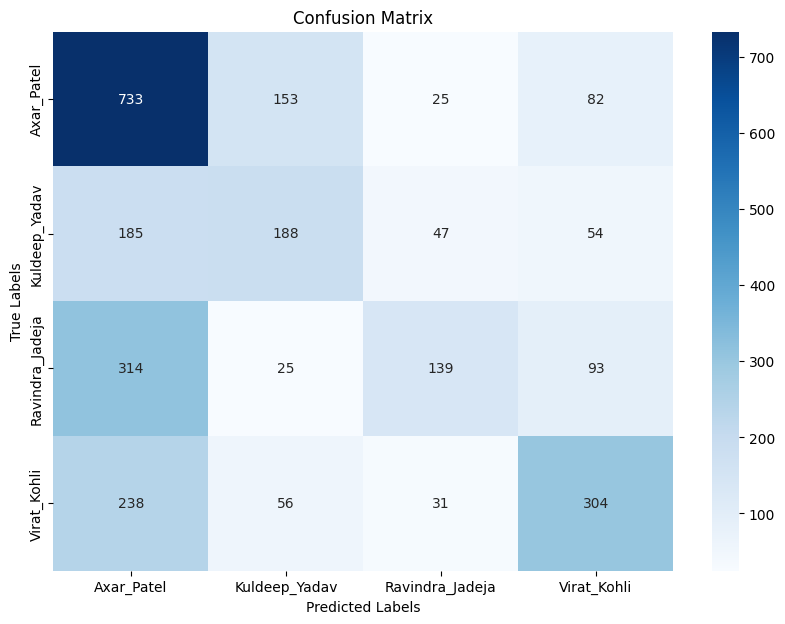

Training completed!


In [14]:
def main():
    output_frame_folder = 'extracted_frames'
    net, output_layers = load_yolo()
    images, labels = load_and_preprocess_data(output_frame_folder, net, output_layers)
    
    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    categorical_labels = to_categorical(encoded_labels)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(images, categorical_labels, test_size=0.2, random_state=42)
    
    # Feature extraction for ViT
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
    X_train = feature_extractor(images=X_train, return_tensors="tf").pixel_values
    X_test = feature_extractor(images=X_test, return_tensors="tf").pixel_values
    
    # Build and train the model
    model = build_model(len(encoder.classes_), encoder)
    history = compile_and_train(model, X_train, y_train, X_test, y_test)

    # Plot training history
    plot_history(history)

    # Evaluate the model
    evaluate_model(X_test, y_test, model, encoder)
    
    # Save the model and the feature extractor
    model.save_pretrained('vit_model_01/vit_spatial_model')
    np.save('vit_model_01/label_encoder_classes.npy', encoder.classes_)
    feature_extractor.save_pretrained('vit_model_01/feature_extractor')

    print("Training completed!")

if __name__ == "__main__":
    main()

In [21]:
import cv2
import numpy as np
import os
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.preprocessing import LabelEncoder


def extract_frames_for_prediction(video_path, output_folder, net, output_layers, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // num_frames if total_frames > num_frames else 1
    frame_ids = [int(interval * i) for i in range(num_frames)]
    frames = []
    feature_extractor = ViTFeatureExtractor.from_pretrained('vit_model_01/feature_extractor')  # Load locally saved feature extractor

    try:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
    except OSError:
        print(f"Error: Creating directory {output_folder}")

    frame_count = 0
    while frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count in frame_ids:
            boxes = yolo_detect(net, frame, output_layers)
            if boxes:
                x, y, w, h = boxes[0]
                cropped_frame = frame[y:y+h, x:x+w]
                resized_frame = cv2.resize(cropped_frame, (224, 224))
                inputs = feature_extractor(images=resized_frame, return_tensors="np")
                frames.append(inputs['pixel_values'][0])
            else:
                print(f"No valid detections at frame {frame_count}.")
        frame_count += 1

    cap.release()
    return np.array(frames)

def predict_player(video_path):
    frame_folder = 'temp_frames'
    net, output_layers = load_yolo()
    model = TFAutoModelForImageClassification.from_pretrained('vit_model_01/vit_spatial_model')  # Load locally saved model
    encoder = LabelEncoder()
    encoder.classes_ = np.load('vit_model_01/label_encoder_classes.npy', allow_pickle=True)
    frames = extract_frames_for_prediction(video_path, frame_folder, net, output_layers)
    if frames.size == 0:
        return "No frames to analyze or no valid detections."

    predictions = model.predict(frames)['logits']
    predicted_class = np.argmax(np.mean(predictions, axis=0))
    predicted_player = encoder.inverse_transform([predicted_class])[0]

    return predicted_player

# Example usage
video_path = 'test_video/1.mov'  
result = predict_player(video_path)
print(f"The player in the video is: {result}")


All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at vit_spatial_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
/Users/pubudusenarathne/Library/Python/3.9/lib/python/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


1/1 [==============================] - 2s 2s/step
The player in the video is: Virat_Kohli
